# Semi Supervised Learning

# Implementation Details and Discussion

* Semi-supervised Learning is an machine learning approach that deals 
with both label and unlabeled data
* The volume of labeled data is very little compared to unlabeled data
* Semi supervised learning methods actually use the unlabeled data to modify or to change the priority of the data obtained from labeled data. Some methods are probabilistics also. 
 

# Loading the MNIST Dataset

In [ ]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt
import tensorflow as tf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision


Defining params

In [ ]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 444
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
init_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


val_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [ ]:
len(init_dataset)


60000

## Data Split (Semi-Supervision based Learning)

In [ ]:
lengths = [int(len(init_dataset)*0.3), int(len(init_dataset)*0.7)]
labeled_subsetA, unlabeled_subsetB = random_split(init_dataset, lengths)



train_unlabeled_data = [(unlabeled_subsetB[i][0],-1) for i in range(len(unlabeled_subsetB))]
len(train_unlabeled_data)

42000

In [ ]:
def get_data_loaders(train_labeled_data, train_unlabeled_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_labeled_data, batch_size=train_batch_size, shuffle=True)
    train_unlabeled_loader = DataLoader(train_unlabeled_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False,)



    return train_loader,train_unlabeled_loader, val_loader

In [ ]:
batch_size_train = 64
batch_size_test = 1000

train_labeled_loader2,train_unlabeled_loader2,val_loader2 =  get_data_loaders(labeled_subsetA, train_unlabeled_data,val_dataset, batch_size_train, batch_size_test)

In [ ]:
batch1 = next(iter(train_loader))
print(batch1[0].shape)
print(batch1[1].shape)
len(batch1)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Structure of NN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(val_loader2.dataset) for i in range(n_epochs + 1)]

## Training and Run

Taking 10 epochs for optimality

In [ ]:
num_cycles = 10
# training
def train2(epoch=10):
    network.train()
    
    #pre-training without unlabeled data 
    if epoch > num_cycles:
        for batch_idx, (data, target) in enumerate(train_unlabeled_loader2):
            network.eval()
            output = network(data)
            fake_target = (output.data.max(1)[1].view(-1)) # using pseudo label method and get pseudo labels
            network.train()
            #data.volatile = False
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, fake_target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_unlabeled_loader2.dataset),
                    100. * batch_idx / len(train_unlabeled_loader2), loss.item()))

    avg_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_labeled_loader2):
        
        
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_labeled_loader2.dataset),
                100. * batch_idx / len(train_labeled_loader2), loss.item()))
            avg_train_loss += loss.item()
            train_losses.append(loss.item())
            train_counter.append(
              (batch_idx*64) + ((epoch-1)*len(train_labeled_loader2.dataset)))
     
    avg_train_loss = avg_train_loss / (len(train_labeled_loader2) / 500)
    #loss_compare.write(str(avg_train_loss) + ',') # no need for now



In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader2: #modifing it : test_loader
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader2.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader2.dataset),
    100. * correct / len(val_loader2.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train2(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/18000 (0%)]	Loss: 2.327318
Train Epoch: 1 [640/18000 (4%)]	Loss: 2.297417
Train Epoch: 1 [1280/18000 (7%)]	Loss: 2.304221
Train Epoch: 1 [1920/18000 (11%)]	Loss: 2.239717
Train Epoch: 1 [2560/18000 (14%)]	Loss: 2.232871
Train Epoch: 1 [3200/18000 (18%)]	Loss: 2.177955
Train Epoch: 1 [3840/18000 (21%)]	Loss: 2.265682
Train Epoch: 1 [4480/18000 (25%)]	Loss: 2.169823
Train Epoch: 1 [5120/18000 (28%)]	Loss: 2.085249
Train Epoch: 1 [5760/18000 (32%)]	Loss: 2.116937
Train Epoch: 1 [6400/18000 (35%)]	Loss: 1.974185
Train Epoch: 1 [7040/18000 (39%)]	Loss: 1.758047
Train Epoch: 1 [7680/18000 (43%)]	Loss: 1.660230
Train Epoch: 1 [8320/18000 (46%)]	Loss: 1.659180
Train Epoch: 1 [8960/18000 (50%)]	Loss: 1.579361
Train Epoch: 1 [9600/18000 (53%)]	Loss: 1.465800
Train Epoch: 1 [10240/18000 (57%)]	Loss: 1.253776
Train Epoch: 1 [10880/18000 (60%)]	Loss: 1.290704
Train Epoch: 1 [11520/18000 (64%)]	Loss: 1.257462
Train Epoch: 1 [12160/18000 (67%)]	Loss: 1.224267
Train Epoch: 1 [12800/1

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.4686, Accuracy: 8876/10000 (89%)

Train Epoch: 2 [0/18000 (0%)]	Loss: 0.977846
Train Epoch: 2 [640/18000 (4%)]	Loss: 0.860509
Train Epoch: 2 [1280/18000 (7%)]	Loss: 0.804900
Train Epoch: 2 [1920/18000 (11%)]	Loss: 0.874034
Train Epoch: 2 [2560/18000 (14%)]	Loss: 0.637267
Train Epoch: 2 [3200/18000 (18%)]	Loss: 0.687312
Train Epoch: 2 [3840/18000 (21%)]	Loss: 0.823312
Train Epoch: 2 [4480/18000 (25%)]	Loss: 0.738046
Train Epoch: 2 [5120/18000 (28%)]	Loss: 0.732257
Train Epoch: 2 [5760/18000 (32%)]	Loss: 0.731674
Train Epoch: 2 [6400/18000 (35%)]	Loss: 0.421929
Train Epoch: 2 [7040/18000 (39%)]	Loss: 0.703925
Train Epoch: 2 [7680/18000 (43%)]	Loss: 0.608449
Train Epoch: 2 [8320/18000 (46%)]	Loss: 0.851965
Train Epoch: 2 [8960/18000 (50%)]	Loss: 0.912012
Train Epoch: 2 [9600/18000 (53%)]	Loss: 0.964750
Train Epoch: 2 [10240/18000 (57%)]	Loss: 0.688519
Train Epoch: 2 [10880/18000 (60%)]	Loss: 0.832637
Train Epoch: 2 [11520/18000 (64%)]	Loss: 0.670635
Train Epoch: 2 

In [ ]:
# fixing the shape issue
print(n_epochs)
len(test_losses)

len(test_counter)

5


6

In [ ]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Accuracy

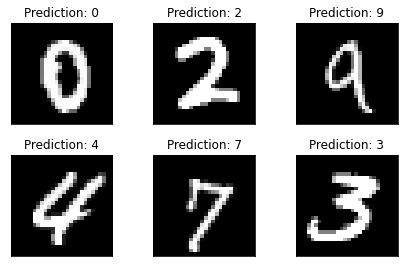

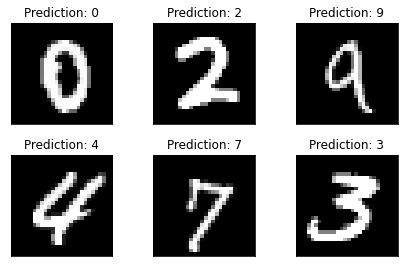

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig